In [2]:
cd /mnt/scratch/metric-synth-runs/

/mnt/scratch/metric-synth-runs


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from shared import load, plot_ablations, method_table, construct_table
import os

plt.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.preamble": "\n".join(
            [r"\documentclass[acmsmall,review,timestamp]{acmart}"]
        ),
    }
)

In [42]:
metric = load('2022-11-03-18:14:20/')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 4212/4212 [00:00<00:00, 8080.12it/s]


In [5]:
enum = load('regex-enum')

100%|███████████████████████████████████████████████████████████████████████████| 4212/4212 [00:01<00:00, 3271.60it/s]


In [6]:
abst = load('regex-abs')

100%|███████████████████████████████████████████████████████████████████████████| 4212/4212 [00:01<00:00, 2535.94it/s]


In [175]:
metric.groupby('bench').mean()['runtime'].sort_values(ascending=False).describe()

count    103.000000
mean       6.994654
std       18.375893
min        0.031680
25%        0.622608
50%        2.398035
75%        5.923555
max      164.822949
Name: runtime, dtype: float64

In [192]:
metric.groupby(['n_groups', 'threshold', 'max_cost', 'extract', 'repair', 'rank']).agg({'success':['mean','count'], 
                                                       'runtime':['min', 'median', 'max'],
                                                       'program_size':['min', 'median', 'max']})

success         runtime  \
                                                      mean count       min   
n_groups threshold max_cost extract repair rank                              
200      0.0       20       Greedy  Guided True   0.722933  2032  0.000904   
         0.3       20       Greedy  Guided False  0.547244  2032  0.109985   
                                           True   0.755413  2032  0.000908   
                                    Random True   0.714075  2032  0.000933   
                            Random  Guided True   0.727854  2032  0.000937   

                                                                        \
                                                    median         max   
n_groups threshold max_cost extract repair rank                          
200      0.0       20       Greedy  Guided True   1.499489  241.308482   
         0.3       20       Greedy  Guided False  0.708278  242.164059   
                                           True   0.742452  273.006955   
                                    Random True   0.656361  281.861798   
                            Random  Guided True   0.682540  273.216948   

                                                 program_size                
                                                          min median    max  
n_groups threshold max_cost extract repair rank                              
200      0.0       20       Greedy  Guided True           2.0   22.0   97.0  
         0.3       20       Greedy  Guided False          2.0   27.0   76.0  
                                           True           2.0   19.0  109.0  
                                    Random True           2.0   18.0  109.0  
                            Random  Guided True           2.0   20.0  109.0

<AxesSubplot:xlabel='Number of sketches solved', ylabel='Time (s)'>

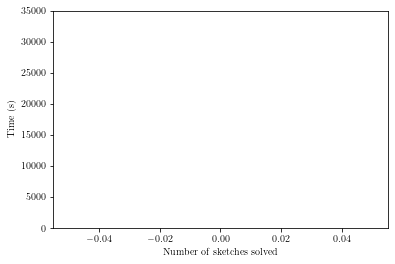

In [177]:

df[(df['n_groups']==200)&\
   (df['threshold']>0)&\
   (df['extract']=='Greedy')&\
   (df['repair']=='Guided')&\
   (df['rank'])]['runtime'].sort_values(ignore_index=True).cumsum().plot(ylim=(0, 3.5*10**4), xlabel='Number of sketches solved', ylabel='Time (s)')

In [8]:
def load_regel(d):
    times = []
    for fn in os.listdir(d):
        with open(d + '/' + fn, 'r') as f:
            x = f.readlines()
        for line in x:
            if 'Total time:' in line:
                time = float(line.split(':')[1])
                times.append(time)
                break
    return times
                
regel_df = pd.DataFrame({'runtime': load_regel('/home/feser/regel-runs/mode1')})
regel_df

,runtime
0,2.126
1,0.008
2,0.019
3,0.238
4,3.041
...,...
1320,13.551
1321,26.104
1322,13.890
1323,0.861


In [11]:
n_bench = 2174

Std solved: 1614
FTA solved: 1430
Abs solved: 278
Regel solved: 1325


<Figure size 432x288 with 0 Axes>

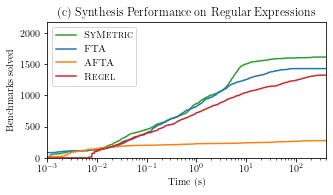

In [47]:
def plot():
    plt.tight_layout()
    fig = plt.figure(figsize=(5, 2.5))
    ax = fig.add_subplot(1, 1, 1)

    std = metric[
        (metric["extract"] == "Exhaustive")
        & (metric["repair"] == "Guided")
        & (metric["threshold"] > 0)
        & (metric["rank"])
    ]["runtime"]
    print('Std solved:', len(std.dropna()))
    std = std.sort_values().fillna(1e10)
    ax.plot(
        [0] + list(std), range(0, len(std) + 1), label=r"\textsc{SyMetric}", color="C2"
    )

    en = enum["runtime"]
    print('FTA solved:', len(en.dropna()))
    en = en.sort_values().fillna(1e10)
    ax.plot(
        [0] + list(en),
        range(0, len(en) + 1),
        label=r"\textsc{FTA}",
        color="C0",
    )

    abstr = abst["runtime"]
    print('Abs solved:', len(abstr.dropna()))
    abstr = abstr.sort_values().fillna(1e10)
    ax.plot(
        [0] + list(abstr),
        range(0, len(abstr) + 1),
        label=r"\textsc{AFTA}",
        color="C1",
    )
    
    reg = regel_df['runtime']
    print('Regel solved:', len(reg.dropna()))
    reg = reg.sort_values().fillna(1e10)
    ax.plot(
        [0] + list(reg) + [1e10],
        range(0, len(reg) + 2),
        label=r"\textsc{Regel}",
        color="C3",
    )

    ax.set_ylim([0, n_bench])
    ax.set_xlim([1e-3, 400])
    ax.set_xscale('log')
    ax.set_ylabel("Benchmarks solved")
    ax.set_xlabel("Time (s)")
    plt.legend(loc="upper left")
    ax.set_title(r"(c) Synthesis Performance on Regular Expressions")
    plt.savefig('/home/feser/634da4c60a6e2fe917f357dc/metric_synth/regex_comparison.pdf', bbox_inches='tight')
plot()

<Figure size 432x288 with 0 Axes>

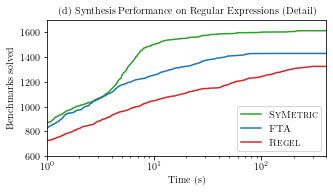

In [44]:
def plot():
    plt.tight_layout()
    fig = plt.figure(figsize=(5, 2.5))
    ax = fig.add_subplot(1, 1, 1)

    std = metric[
        (metric["extract"] == "Exhaustive")
        & (metric["repair"] == "Guided")
        & (metric["threshold"] > 0)
        & (metric["rank"])
    ]["runtime"]
    std = std.sort_values().fillna(1e10)
    ax.plot(
        [0] + list(std), range(0, len(std) + 1), label=r"\textsc{SyMetric}", color="C2"
    )

    en = enum["runtime"]
    en = en.sort_values().fillna(1e10)
    ax.plot(
        [0] + list(en),
        range(0, len(en) + 1),
        label=r"\textsc{FTA}",
        color="C0",
    )
    
    reg = regel_df['runtime']
    reg = reg.sort_values().fillna(1e10)
    ax.plot(
        [0] + list(reg) + [1e10],
        range(0, len(reg) + 2),
        label=r"\textsc{Regel}",
        color="C3",
    )

    ax.set_ylim([600, 1700])
    ax.set_xlim([1, 400])
    ax.set_xscale('log')
    ax.set_ylabel("Benchmarks solved")
    ax.set_xlabel("Time (s)")
    plt.legend(loc="lower right")
    ax.set_title(r"(d) Synthesis Performance on Regular Expressions (Detail)", fontsize=10)
    plt.savefig('/home/feser/634da4c60a6e2fe917f357dc/metric_synth/regex_hard_comparison.pdf', bbox_inches='tight')
plot()

In [38]:
with open('/home/jovyan/work/home/feser/metric_synth/regex_method_times.tex', 'w') as f:
    method_table(df, file=f)
with open('/home/jovyan/work/home/feser/metric_synth/regex_construct_times.tex', 'w') as f:
    construct_table(df, file=f)

/home/jovyan/work/home/feser/work/ocaml-workspace/staged-synth/notebooks/shared.py:191: FutureWarning: ['method', 'filename', 'extract', 'repair'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df[df["success"]].agg(["median", "max"])
/home/jovyan/work/home/feser/work/ocaml-workspace/staged-synth/notebooks/shared.py:218: FutureWarning: ['method', 'filename', 'extract', 'repair'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df = df[df["success"]].agg(["median", "max"])
